In [144]:
import pandas as pd

# Define the word groups
categories = {
    'Me': ['I', 'myself', 'my', 'mine', 'self'],
    'Not me': ['they', 'them', 'their', 'theirs', 'other'],
    'Death': ['die', 'funeral', 'deceased', 'lifeless', 'suicide'],
    'Life': ['alive', 'survive', 'thrive', 'breathing', 'live']
}


In [145]:
# Function to categorize 'Stim'
def categorize_stim(stim):
    for category, words in categories.items():
        if stim in words:
            return category
    return 'Unknown'  # In case the word does not match any category

# Create the 'Match' column based on 'Category' and 'BlockType'
def match_category(row):
    if row['BlockType'] == 'life-me':
        if row['Category'] in ['Life', 'Me']:
            return 1
    elif row['BlockType'] == 'death-me':
        if row['Category'] in ['Death', 'Me']:
            return 1
    return 0

# Create the 'Type' column where 'life-me' is mapped to 1 and 'death-me' to 2
def map_type(block_type):
    if block_type == 'life-me':
        return 1
    elif block_type == 'death-me':
        return 2
    return 0

['309_toi4iat_2024-05-21_14-39-09_1.metrics.csv']
['301_toi4iat_2024-04-25_10-56-28_1.metrics.csv']
['304_toi4iat_2024-04-22_14-10-26_1.metrics.csv']
['311_toi4iat_2024-05-29_10-34-52_1.metrics.csv']
['310_toi4iat_2024-05-23_09-47-18_1.metrics.csv']


13

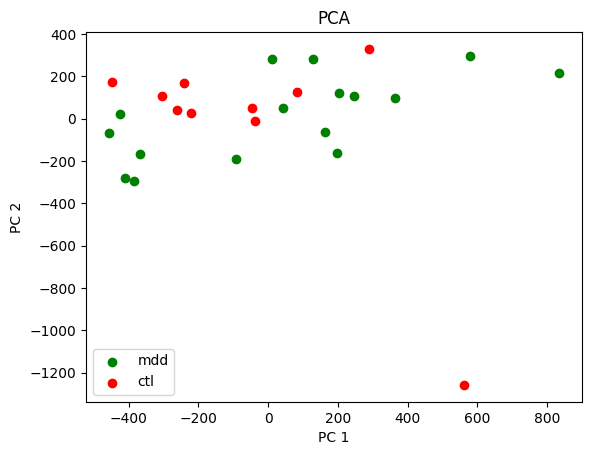

In [146]:
import os
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
plt.style.use('classic')  

pca = PCA(n_components=2)

mdd_dir = '/Users/applepie/Library/CloudStorage/OneDrive-WorcesterPolytechnicInstitute(wpi.edu)/toi4_new 2/mdd'
mdd_paths = os.listdir(mdd_dir)
mdd_paths = [path for path in mdd_paths if not path.startswith('.') and path.startswith('3')]

points = np.zeros((26, 18))

for i, subject in enumerate(mdd_paths):
    paths = os.listdir(f'{mdd_dir}/{subject}/1/')
    path = [path for path in paths if path.startswith(f'{subject}_toi4iat') and path.endswith('metrics.csv')][0]
    df = pd.read_csv(f'{mdd_dir}/{subject}/1/{path}')
    df = df[df['BlockNumber'] >= 0]  
    df['Category'] = df['Stim'].apply(categorize_stim)
    df['Match'] = df.apply(match_category, axis=1)
    df['Type'] = df['BlockType'].apply(map_type)
    
    match = np.array(df[df['Match'].astype(bool)].groupby(['BlockNumber'])['ResponseTime'].mean())
    no_match = np.array(df[~df['Match'].astype(bool)].groupby(['BlockNumber'])['ResponseTime'].mean())
    
    points[i] = no_match
    points[i+len(mdd_paths)] = match
    
ctl_dir = '/Users/applepie/Library/CloudStorage/OneDrive-WorcesterPolytechnicInstitute(wpi.edu)/ctl'

ctl_paths = os.listdir(ctl_dir)
ctl_paths = [path for path in ctl_paths if not path.startswith('.') and (path.startswith('3') or path.startswith('3'))]
for i, subject in enumerate(ctl_paths):#enumerate(ctl_paths):
    paths = os.listdir(f'{ctl_dir}/{subject}/1/')
    path = [path for path in paths if path.startswith(f'{subject}_toi4iat') and path.endswith('metrics.csv')][-1]
    print([path for path in paths if path.startswith(f'{subject}_toi4iat') and path.endswith('metrics.csv')])
    df = pd.read_csv(f'{ctl_dir}/{subject}/1/{path}')
    
    df = df[df['BlockNumber'] >= 0]  
    df['Category'] = df['Stim'].apply(categorize_stim)
    df['Match'] = df.apply(match_category, axis=1)
    df['Type'] = df['BlockType'].apply(map_type)

    match = np.array(df[df['Match'].astype(bool)].groupby(['BlockNumber'])['ResponseTime'].mean())
    no_match = np.array(df[~df['Match'].astype(bool)].groupby(['BlockNumber'])['ResponseTime'].mean())

    points[i+2*len(mdd_paths)] = no_match
    points[i+2*len(mdd_paths)+len(ctl_paths)] = match
    

plt.style.use('default')

projected_points = pca.fit_transform(points)
plt.title('PCA')
plt.scatter(projected_points[:16, 0], projected_points[:16, 1], color='green', label='mdd')
plt.scatter(projected_points[16:, 0], projected_points[16:, 1], color='red', label='ctl')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()

len(ctl_paths+mdd_paths)

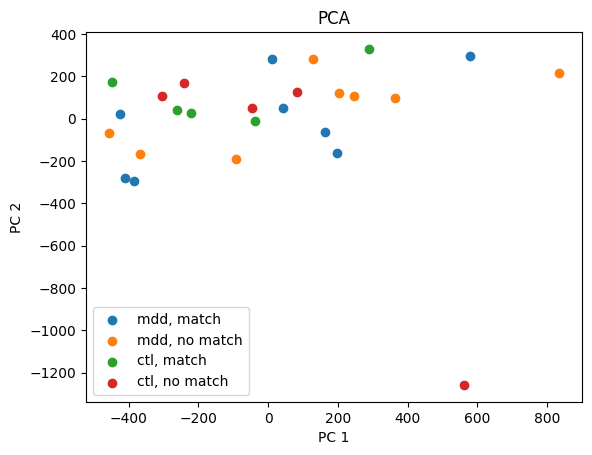

In [147]:
import os
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import re

plt.style.use('default')  

def get_point(path):
    filenames = os.listdir(path)
    csv_filename = [filename for filename in filenames if re.search('toi4iat.*metrics.csv$', filename)][0]
    df = pd.read_csv(f'{path}/{csv_filename}')
    df = df[df['BlockNumber'] >= 0]  
    df['Category'] = df['Stim'].apply(categorize_stim)
    df['Match'] = df.apply(match_category, axis=1)
    df['Type'] = df['BlockType'].apply(map_type)

    match = np.array(df[df['Match'].astype(bool)].groupby(['BlockNumber'])['ResponseTime'].mean())
    no_match = np.array(df[~df['Match'].astype(bool)].groupby(['BlockNumber'])['ResponseTime'].mean())
    
    return match, no_match

pca = PCA(n_components=2)

subject_df = pd.DataFrame(columns=['subject_type', 'match'])

mdd_dir = '/Users/applepie/Library/CloudStorage/OneDrive-WorcesterPolytechnicInstitute(wpi.edu)/toi4_new 2/mdd'
mdd_paths = [('mdd', f'{mdd_dir}/{subject}/1/') for subject in os.listdir(mdd_dir) if subject.startswith('3')]

ctl_dir = '/Users/applepie/Library/CloudStorage/OneDrive-WorcesterPolytechnicInstitute(wpi.edu)/ctl'
ctl_paths = [('ctl', f'{ctl_dir}/{subject}/1/') for subject in os.listdir(ctl_dir) if subject.startswith('3')]

paths = mdd_paths + ctl_paths
points = np.zeros((2*len(paths), 18))

for i, (subject_type, path) in enumerate(paths):
    match, no_match = get_point(path)
    subject_df.loc[len(subject_df)] = { 'subject_type': subject_type, 'match': 'match'}
    subject_df.loc[len(subject_df)] = { 'subject_type': subject_type, 'match': 'no match'}
    points[2*i] = match
    points[2*i+1] = no_match
    
plt.style.use('default')


# points = np.log(points)
projected_points = pca.fit_transform(points)
whole_enchilada = pd.concat([subject_df, pd.DataFrame(projected_points)], axis=1)
mdd_points = whole_enchilada[whole_enchilada['subject_type'] == 'mdd']
ctl_points = whole_enchilada[whole_enchilada['subject_type'] == 'ctl']
mdd_match = mdd_points[mdd_points['match'] == 'match']
mdd_no_match = mdd_points[mdd_points['match'] == 'no match']
ctl_match = ctl_points[ctl_points['match'] == 'match']
ctl_no_match = ctl_points[ctl_points['match'] == 'no match']
plt.title('PCA')
plt.scatter(mdd_match[0], mdd_match[1], label='mdd, match')
plt.scatter(mdd_no_match[0], mdd_no_match[1], label='mdd, no match')
plt.scatter(ctl_match[0], ctl_match[1], label='ctl, match')
plt.scatter(ctl_no_match[0], ctl_no_match[1], label='ctl, no match')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.savefig('figures/pca')

In [148]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

avg_rt_df = pd.concat([subject_df, pd.DataFrame(points)], axis=1)

stacked_matrix = np.tile(np.eye(18, 18), (26, 1))

# rows = np.arange(18*26)
# cols = np.tile(np.arange(18), 26)
# 
# stacked_matrix[rows, cols] = points.flatten()

lr.fit(stacked_matrix, np.log(points.ravel()))
lr.coef_

array([-2.69416804e+12, -2.69416804e+12, -2.69416804e+12, -2.69416804e+12,
       -2.69416804e+12, -2.69416804e+12, -2.69416804e+12, -2.69416804e+12,
       -2.69416804e+12, -2.69416804e+12, -2.69416804e+12, -2.69416804e+12,
       -2.69416804e+12, -2.69416804e+12, -2.69416804e+12, -2.69416804e+12,
       -2.69416804e+12, -2.69416804e+12])

In [149]:
import numpy as np

# Assuming your original 26x17 matrix is named 'dense_matrix'
dense_matrix = np.random.rand(26, 17)  # Example matrix, replace with your actual matrix

# Get the number of rows and columns of the dense matrix
num_rows, num_cols = dense_matrix.shape

# Create an empty 442x17 matrix
transformed_matrix = np.zeros((num_rows * num_cols, num_cols))

# Create an array of indices for rows
row_indices = np.arange(num_rows * num_cols)

# Create an array of indices for columns
col_indices = np.tile(np.arange(num_cols), num_rows)

# Use advanced indexing to place elements in the correct positions
transformed_matrix[row_indices, col_indices] = dense_matrix.flatten()

print(transformed_matrix)


[[0.45445556 0.         0.         ... 0.         0.         0.        ]
 [0.         0.80730553 0.         ... 0.         0.         0.        ]
 [0.         0.         0.816321   ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.15162428 0.         0.        ]
 [0.         0.         0.         ... 0.         0.57278556 0.        ]
 [0.         0.         0.         ... 0.         0.         0.38963174]]


In [150]:
from sklearn.manifold import TSNE

def graph_tsne(perplexity, seed):
    tsne = TSNE(n_components=2, random_state=seed, perplexity=perplexity)
    projected_points = tsne.fit_transform(points)
    whole_enchilada = pd.concat([subject_df, pd.DataFrame(projected_points)], axis=1)
    mdd_points = whole_enchilada[whole_enchilada['subject_type'] == 'mdd']
    ctl_points = whole_enchilada[whole_enchilada['subject_type'] == 'ctl']
    mdd_match = mdd_points[mdd_points['match'] == 'match']
    mdd_no_match = mdd_points[mdd_points['match'] == 'no match']
    ctl_match = ctl_points[ctl_points['match'] == 'match']
    ctl_no_match = ctl_points[ctl_points['match'] == 'no match']
    plt.title(f'TSNE (seed={seed}, perplexity={perplexity})')
    plt.scatter(mdd_match[0], mdd_match[1], label='mdd, match')
    plt.scatter(mdd_no_match[0], mdd_no_match[1], label='mdd, no match')
    plt.scatter(ctl_match[0], ctl_match[1], label='ctl, match')
    plt.scatter(ctl_no_match[0], ctl_no_match[1], label='ctl, no match')
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.legend()
    plt.savefig(f'figures/tsne_perp-{perplexity}_seed-{seed}')
    plt.clf()
    
for seed in range(5):
    for perplexity in range(5, 15):
        graph_tsne(perplexity, seed)



<Figure size 640x480 with 0 Axes>

In [151]:
data_dict = {
    203: [0.0, 0.0],
    201: [0.0, 0.0],
    204: [0.0, 0.0],
    202: [0.0, 0.0],
    207: [0.0, 0.0],
    206: [0.011904762, 0.0],
    208: [0.077380952, 0.0],
    209: [0.238095238, 0.079365079],
    210: [0.0, 0.0],
    211: [0.0, 0.0],
    212: [0.290000000, 0.080000000],
    306: [0.404761905, 0.174603175],
    307: [0.386904762, 0.063492063],
    308: [0.250000000, 0.0],
    309: [0.0, 0.0],
    310: [0.0, 0.0],
    311: [0.017441860, 0.0],
    313: [0.250000000, 0.079365079],
    314: [0.660714286, 0.301587302],
    315: [0.029761905, 0.015873016],
    316: [0.892857143, 0.317460317],
    317: [0.571428571, 0.0],
    318: [0.0, 0.0],
    320: [0.095238095, 0.023809524],
    321: [0.0, 0.0],
    323: [0.0, 0.0],
    322: [0.086206897, 0.0]
}

print(data_dict)


{203: [0.0, 0.0], 201: [0.0, 0.0], 204: [0.0, 0.0], 202: [0.0, 0.0], 207: [0.0, 0.0], 206: [0.011904762, 0.0], 208: [0.077380952, 0.0], 209: [0.238095238, 0.079365079], 210: [0.0, 0.0], 211: [0.0, 0.0], 212: [0.29, 0.08], 306: [0.404761905, 0.174603175], 307: [0.386904762, 0.063492063], 308: [0.25, 0.0], 309: [0.0, 0.0], 310: [0.0, 0.0], 311: [0.01744186, 0.0], 313: [0.25, 0.079365079], 314: [0.660714286, 0.301587302], 315: [0.029761905, 0.015873016], 316: [0.892857143, 0.317460317], 317: [0.571428571, 0.0], 318: [0.0, 0.0], 320: [0.095238095, 0.023809524], 321: [0.0, 0.0], 323: [0.0, 0.0], 322: [0.086206897, 0.0]}


pvalues= [4.23879059e-190 3.75320962e-202 4.32906537e-196 1.05681212e-193
 3.51277502e-005] weights= [ 5.55387744  1.34772187  1.45079629  1.3965398   1.35881948 -0.1028806 ]
pvalues= [5.71611620e-173 1.12395085e-192 1.88193833e-189 4.79285674e-184
 2.08877639e-005] weights= [ 5.44479654  1.24477079  1.44198455  1.40923142  1.34880979 -0.11335911]
pvalues= [7.43564090e-149 4.93292968e-163 3.07377792e-155 3.20108181e-144
 3.89916628e-002] weights= [5.20225871 1.25458102 1.40888024 1.32387211 1.21492534 0.06559818]
pvalues= [9.64596697e-93 1.62703787e-94 1.92564969e-94 4.47964948e-96
 2.34983862e-01] weights= [10.78963505  2.62537004  2.69335811  2.68928434  2.78162256  0.05360235]
pvalues= [5.15924423e-167 2.59328350e-174 3.25107836e-174 9.24532998e-160
 2.76710850e-002] weights= [5.22026215 1.28513229 1.36257431 1.35468293 1.21787262 0.06272176]
pvalues= [6.76476672e-173 2.61276939e-186 1.87918643e-183 4.90087431e-178
 3.20099945e-006] weights= [ 5.4275664   1.28657024  1.4171237   1.3

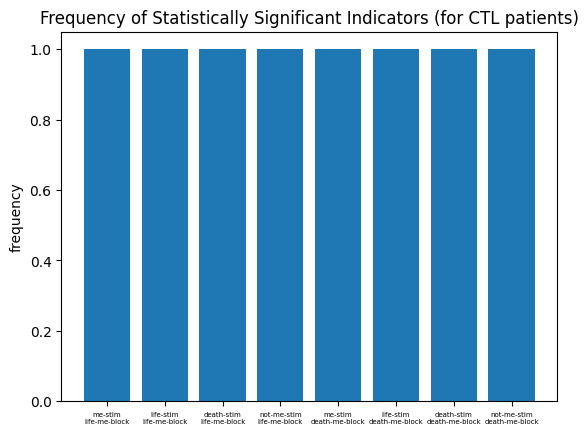

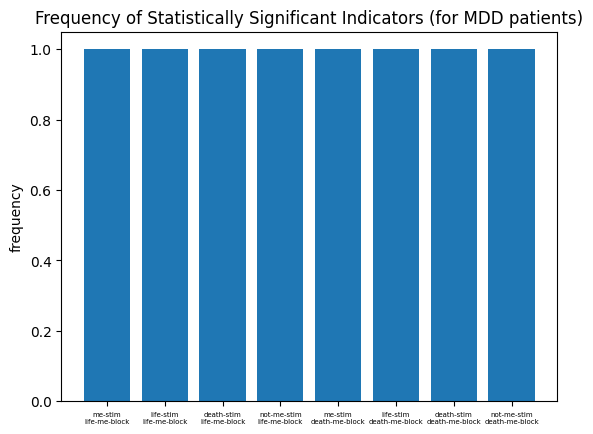

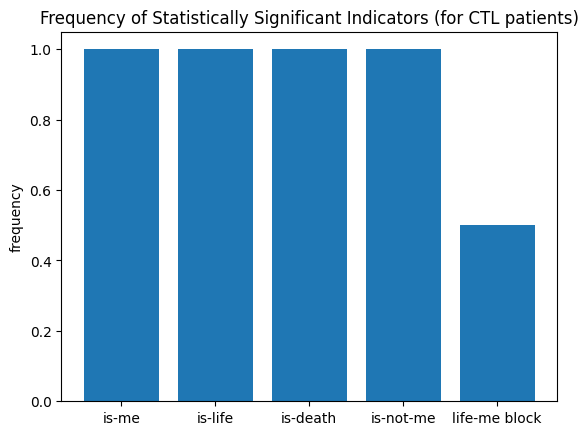

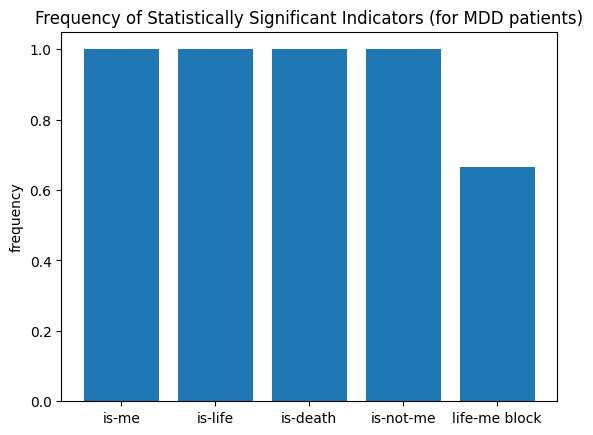

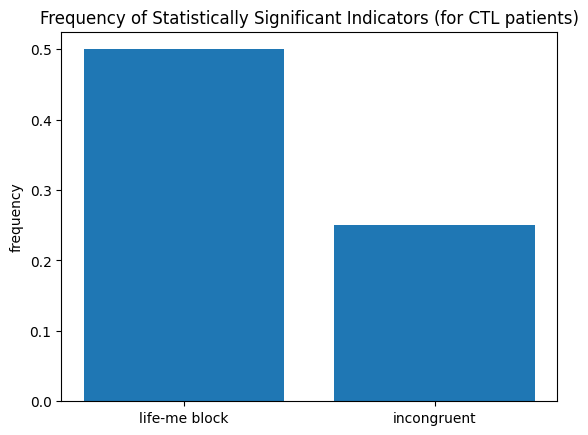

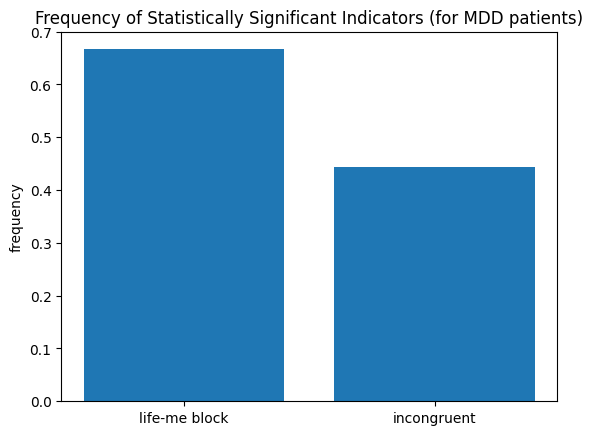

<Figure size 640x480 with 0 Axes>

In [241]:
import statsmodels.api as sm

def get_point(path):
    filenames = os.listdir(path)
    csv_filename = [filename for filename in filenames if re.search('toi4iat.*metrics.csv$', filename)][0]
    df = pd.read_csv(f'{path}/{csv_filename}')
    df = df[df['BlockNumber'] >= 0]  
    df['Category'] = df['Stim'].apply(categorize_stim)
    df['Type'] = df['BlockType'].apply(map_type)
    return df

def count_sigs(point, columns):
    x_sm = point[columns].to_numpy()
    x_sm = sm.add_constant(x_sm)
    y_sm = np.log(point['ResponseTime'].to_numpy()).reshape(-1, 1)
    sm_model = sm.OLS(y_sm, x_sm).fit()
    counts = sm_model.pvalues[1:] <= .05
    if len(columns) == 5:
        print('pvalues=',sm_model.pvalues[1:], 'weights=',sm_model.params[:])
        # print(sm_model.pvalues[1:])
        # print(x_sm.shape)
    return counts

model_2_cats = ['life-me block', 'incongruent']
model_5_cats = ['is-me', 'is-life', 'is-death', 'is-not-me', 'life-me block']
model_8_cats = ['me-stim life-me-block', 'life-stim life-me-block', 'death-stim life-me-block', 'not-me-stim life-me-block', 'me-stim death-me-block', 'life-stim death-me-block', 'death-stim death-me-block', 'not-me-stim death-me-block']


pca = PCA(n_components=2)

subject_df = pd.DataFrame(columns=['subject_type', 'match'])

mdd_dir = '/Users/applepie/Library/CloudStorage/OneDrive-WorcesterPolytechnicInstitute(wpi.edu)/toi4_new 2/mdd'
mdd_paths = [('mdd', f'{mdd_dir}/{subject}/1/') for subject in os.listdir(mdd_dir) if subject.startswith('3') or subject.startswith('2')]

ctl_dir = '/Users/applepie/Library/CloudStorage/OneDrive-WorcesterPolytechnicInstitute(wpi.edu)/ctl'
ctl_paths = [('ctl', f'{ctl_dir}/{subject}/1/') for subject in os.listdir(ctl_dir) if subject.startswith('3') or subject.startswith('2')]

paths = mdd_paths + ctl_paths
points = np.zeros((2*len(paths), 18))

ctl_coef = []
ctl_si_score = []
mdd_coef = []
mdd_si_score = []

# stat_sigs = np.zeros((len(paths), 5))
model_2_counts_ctl = np.zeros((len(model_2_cats),))
model_5_counts_ctl = np.zeros((len(model_5_cats),))
model_8_counts_ctl = np.zeros((len(model_8_cats),))

model_2_counts_mdd = np.zeros((len(model_2_cats),))
model_5_counts_mdd = np.zeros((len(model_5_cats),))
model_8_counts_mdd = np.zeros((len(model_8_cats),))

# model_8_coef = []

lr_df = pd.DataFrame(columns=['subject', 'p1', 'p2'])
for i, (subject_type, path) in enumerate(paths):
    point = get_point(path)
    
    # point = point.sample(frac=1).reset_index(drop=True)

    point = point.reset_index()
    point['life-me block'] = (point['BlockType'] == 'life-me').astype(np.float64)
    point['death-me block'] = (point['BlockType'] != 'life-me')
    point['Match'] = point.apply(match_category, axis=1)
    point['incongruent'] = 1 - point['Match']
    
    point['is-me'] = point['Stim'].isin(categories['Me']).astype(np.float64)
    point['is-life'] = point['Stim'].isin(categories['Life']).astype(np.float64)
    point['is-death'] = point['Stim'].isin(categories['Death']).astype(np.float64)
    point['is-not-me'] = point['Stim'].isin(categories['Not me']).astype(np.float64)
    
    point['random'] = pd.Series(np.random.permutation(np.arange(len(point))))
    
    point['half 0 half 1'] = pd.Series([0] * (len(point)//2) + [0]*(len(point)//2 + len(point)%2))
        
    point['me-stim life-me-block'] = (point['Stim'].isin(categories['Me']) & point['life-me block']).astype(np.float64)
    point['life-stim life-me-block'] = (point['Stim'].isin(categories['Life']) & point['life-me block']).astype(np.float64)
    point['death-stim life-me-block'] = (point['Stim'].isin(categories['Death']) & point['life-me block']).astype(np.float64)
    point['not-me-stim life-me-block'] = (point['Stim'].isin(categories['Not me']) & point['life-me block']).astype(np.float64)
    
    point['me-stim death-me-block'] = (point['Stim'].isin(categories['Me']) & point['death-me block']).astype(np.float64)
    point['life-stim death-me-block'] = (point['Stim'].isin(categories['Life']) & point['death-me block']).astype(np.float64)
    point['death-stim death-me-block'] = (point['Stim'].isin(categories['Death']) & point['death-me block']).astype(np.float64)
    point['not-me-stim death-me-block'] = (point['Stim'].isin(categories['Not me']) & point['death-me block']).astype(np.float64)
        
    point = point[point['ResponseTime'] > 0]
    
    subject_name = path[-6:-3]
    if subject_name == '209': continue
        
    lr = LinearRegression()
    lr.fit(point[['life-me block', 'incongruent']], np.log(point['ResponseTime']))
    
    if (subject_type, path) in ctl_paths:
        model_2_counts_ctl += count_sigs(point, model_2_cats)
        model_5_counts_ctl += count_sigs(point, model_5_cats)
        model_8_counts_ctl += count_sigs(point, model_8_cats)
    else:
        model_2_counts_mdd += count_sigs(point, model_2_cats)
        model_5_counts_mdd += count_sigs(point, model_5_cats)
        model_8_counts_mdd += count_sigs(point, model_8_cats)
    
    lr_df.loc[len(lr_df)] = [subject_name, *lr.coef_]
    
    if subject_type == 'ctl':
        ctl_coef.append(list(lr.coef_))
    elif subject_type == 'mdd':
        mdd_coef.append(list(lr.coef_))
    else:
        raise 'uh oh'
    
    try:
        if subject_type == 'ctl':
            ctl_si_score.append(data_dict[int(subject_name)])
        elif subject_type == 'mdd':
            mdd_si_score.append(data_dict[int(subject_name)])
        else:
            raise 'uh oh' 
        
    except:
        pass_si_score = -1
        if subject_name == '205':
            pass_si_score = 0.07738095
        else:
            pass_si_score = 0.
        if subject_type == 'ctl':
            ctl_si_score.append([pass_si_score, '?'])
        elif subject_type == 'mdd':
            mdd_si_score.append([pass_si_score, '?'])
        else:
            raise 'uh oh' 
        
    if path[-6:-3] != '306': continue    
    block_size = point['BlockNumber'].value_counts()[0]     
    pred = lr.predict(point[['life-me block', 'incongruent']])
    stop = 120
    for j in range(0, min(len(point.index), stop), block_size):
        block_number = (j // block_size) + 1
        block_center = j + block_size // 2
        
        block_type_name = 'life-me' if (j/block_size) % 2 == 0 else 'death-me'
        plt.text(block_center, min(pred) - .5, f'{block_type_name}', ha='center', fontsize=9) 
        plt.axvline(x=j - 0.5, color='grey', linestyle='--', linewidth=0.8)

    x_plot = np.arange(len(point.index))[:stop]
    y_plot =  pred[:stop]
    plt.ylim(min(y_plot) - 1, max(y_plot) + 1)
    plt.scatter(x_plot, y_plot, label='predicted RT')
    
    plt.scatter(x_plot[point[:stop]['incongruent'] == 1], np.log(point['ResponseTime'][:stop][point[:stop]['incongruent'] == 1]), label='incongruent true RT')
    
    plt.scatter(x_plot[point[:stop]['incongruent'] == 0], np.log(point['ResponseTime'][:stop][point[:stop]['incongruent'] == 0]), label='congruent true RT')
    
    plt.xlabel('trial no.')
    plt.ylabel('log RT')
    
    plt.title(f'Subject {path[-6:-3]}')
    plt.legend()
        
    plt.clf()
    
new_cats = []
for name in model_8_cats:
    new_cats.append('\n'.join(name.split()))
    
def plot_result(title, cats, counts, num_patients, fontsize=None): 
    plt.title(title)
    plt.bar(cats, counts / num_patients)
    if fontsize is not None:
        plt.xticks(fontsize=fontsize)

    plt.ylabel('frequency')
    plt.show()
    plt.clf()
    
plot_result('Frequency of Statistically Significant Indicators (for CTL patients)', new_cats, model_8_counts_ctl, len(ctl_paths)-1, fontsize=5)

plot_result('Frequency of Statistically Significant Indicators (for MDD patients)', new_cats, model_8_counts_mdd, len(mdd_paths), fontsize=5)

plot_result('Frequency of Statistically Significant Indicators (for CTL patients)', model_5_cats, model_5_counts_ctl, len(ctl_paths)-1)

plot_result('Frequency of Statistically Significant Indicators (for MDD patients)', model_5_cats, model_5_counts_mdd, len(mdd_paths))

plot_result('Frequency of Statistically Significant Indicators (for CTL patients)', model_2_cats, model_2_counts_ctl, len(ctl_paths)-1)

plot_result('Frequency of Statistically Significant Indicators (for MDD patients)', model_2_cats, model_2_counts_mdd, len(mdd_paths))


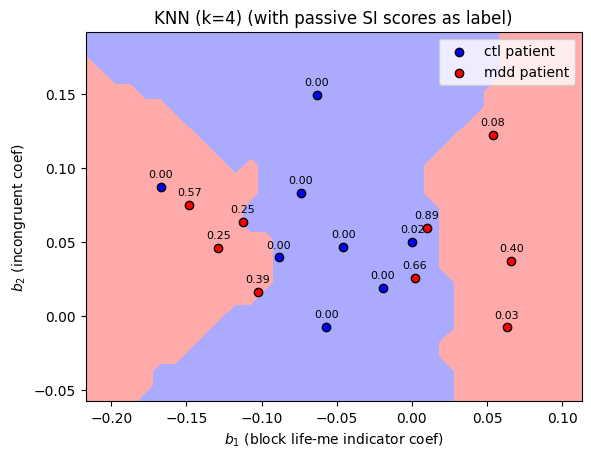

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
import statsmodels.api as sm



X_train = []
Y_train = []
X_train += list(ctl_coef)
Y_train += ['ctl'] * len(ctl_coef)
X_train += list(mdd_coef)
Y_train += ['mdd'] * len(mdd_coef)

n_neighbors = 4
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)

total_coef = list(zip(*(ctl_coef + mdd_coef)))
x_min = np.min(total_coef[0]) - .05
x_max = np.max(total_coef[0]) + .05

y_min = np.min(total_coef[1]) - .05
y_max = np.max(total_coef[1]) + .05

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ['#FF0000', '#0000FF']

plt.contourf(xx, yy, Z == 'ctl', cmap=cmap_light)

plt.scatter(*zip(*ctl_coef), label='ctl patient', edgecolor='k', color='blue')
plt.scatter(*zip(*mdd_coef), label='mdd patient', edgecolor='k', color='red')

ctl_coef_x, ctl_coef_y = zip(*ctl_coef)
mdd_coef_x, mdd_coef_y = zip(*mdd_coef)

X_train_si = []
X_train_si += ctl_si_score
X_train_si += mdd_si_score
for i in range(len(ctl_coef)):
    if not isinstance(ctl_si_score[i][0], float):
        print(ctl_si_score[i][0])
        continue
    plt.text(ctl_coef[i][0], ctl_coef[i][1] + .005, f'{ctl_si_score[i][0]:.2f}',fontsize='8', ha='center', va='bottom')
    
for i in range(len(mdd_coef)):
    if not isinstance(mdd_si_score[i][0], float): continue
    plt.text(mdd_coef[i][0], mdd_coef[i][1]+.005, f'{mdd_si_score[i][0]:.2f}',fontsize='8', ha='center', va='bottom')
    
plt.xlabel('$b_1$ (block life-me indicator coef)')
plt.ylabel('$b_2$ (incongruent coef)')
plt.title(f'KNN (k={n_neighbors}) (with passive SI scores as label)')
plt.legend()

